In [7]:
from astropy.table import Table
from astropy.io import ascii
from astropy import constants as const
import pandas as pd
import numpy as np
import math
import astropy.units as u
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']      #图像中正常显示中文字体
plt.rcParams['axes.unicode_minus'] = False        # 用来正常显示负号

In [8]:
##这里没用
##将cat文件转为csv文件
def cat_to_csv(input_file,output_file):
    t = ascii.read(input_file,comment='##',header_start=65,data_start=66)
    print(t)
    t.write(output_file, format='csv',overwrite=True)

根据公式

$f_\nu = 10^{-0.4 (ABmag+48.6)}$

和 $f_\lambda = f_\nu \frac{d \nu}{d \lambda} = -\frac{c}{\lambda^2}f_\nu$

有 $f_\lambda = \frac{c}{\lambda^2} 10^{-0.4 (ABmag+48.6)} $

In [9]:
#convex ABmag to flux density(flux in unit wavelength)
def ABmag_to_fluxdensity(ABmag,lambda_center):
    f_lambda = (ABmag*u.ABmag).to(u.erg/u.s/u.cm**2/u.AA, u.spectral_density(lambda_center* u.AA))
    return f_lambda

Parameters of filter:

$\alpha_{\mathrm{x}}=\frac{\int \lambda^{2} \mathrm{T}_{\lambda}^{\mathrm{x}} \mathrm{d} \lambda}{\int \mathrm{T}_{\lambda}^{\mathrm{x}} \lambda \mathrm{d} \lambda}$

$ \beta_{\mathrm{x}}=\frac{\mathrm{T}_{\lambda_{\mathrm{EL}}}^{\mathrm{x}} \lambda_{\mathrm{EL}}}{\int \mathrm{T}_{\lambda}^{\mathrm{x}} \lambda \mathrm{d} \lambda}$

In [10]:
def filter_transmission(filterfile,lambda_emissionline):
    t = ascii.read(filterfile,data_start=0)
    df = t.to_pandas()
    df.columns = ['lambda','T']
    df['lambdaT']=df['lambda']*df['T']
    df['lambda2T']=df['lambdaT']*df['lambda']

    int_lambdaT = df['lambdaT'].sum()
    int_lambda2T = df['lambda2T'].sum()
    
    alpha = int_lambda2T/int_lambdaT

    EL_df = df[ df['lambda']==lambda_emissionline.value]
    beta = EL_df['lambda']*EL_df['T']/int_lambdaT
    return alpha,float(beta)


In [11]:
#filter infomation
filter_df = pd.DataFrame(columns = ['uJAVA','J0378','J0395','J0410','J0430','gSDSS','J0515','rSDSS','J0660','iSDSS','J0861','zSDSS'])
                         
filter_df.loc['CW'] = [3485,3785,3950,4100,4300,4803,5150,6254,6600,7668,8610,9114]
filter_df.loc['FWHM'] = [508,168,100,200,200,1409,200,1388,145,1535,400,1409]
for filter in filter_df.columns.values:
    filter_df.at['alpha',filter],filter_df.at['beta',filter] = filter_transmission("JPLUS_"+filter+"_FullEfficiency.tab.txt",3950*u.AA)
                         
#df.to_csv('1000001-JPLUS-filterinfo.csv',index=False)
filter_df

,uJAVA,J0378,J0395,J0410,J0430,gSDSS,J0515,rSDSS,J0660,iSDSS,J0861,zSDSS
CW,3485,3785,3950,4100,4300,4803,5150,6254,6600,7668,8610,9114
FWHM,508,168,100,200,200,1409,200,1388,145,1535,400,1409
alpha,3542,3783.21,3939.72,4109.44,4304.55,4849.26,5141.96,6302.09,6604.33,7694.82,8613.1,9011
beta,0,0,0.00994295,4.83431e-06,0,0.00016558,0,0,0,0,0,0


In [12]:
#read data from JPLUS catalog file(在 71 行开头删去一个#后的文件)

########输入的参数##########
catfile = '1000001-JPLUS-01488-v2'
###########################
#
#在 71 行开头删去一个#，方便读取
with open(catfile,'r+') as f:
    flist=f.readlines()
    flist[70] = flist[70].replace('#',' ')
with open(catfile,'w+') as f:
    f.writelines(flist)
    
#读取cat文件
t = ascii.read(catfile,header_start=0,data_start=1)
cat_df = t.to_pandas()

#save data as csv file.
#df.to_csv('1000001-JPLUS-00525-v2.csv',index=False)

cat_df

,ID,alpha_j2000,delta_j2000,x_image,y_image,isoarea_world,fwhm_world,class_star,ell,a_world,...,irms_J0410,irms_J0430,irms_gSDSS,irms_J0515,irms_rSDSS,irms_J0660,irms_iSDSS,irms_J0861,irms_zSDSS,irms_flag
0,26126-1,110.129171,39.460355,1757.82947,122.533401,4.763755e-08,0.000529,0.510742,0.368073,0.000147,...,0.296533,0.297025,0.298146,0.300140,0.283829,0.301720,0.297666,0.293345,0.287474,None
1,26126-3,110.277274,39.459629,1016.79639,123.354340,9.527511e-08,0.000686,0.493896,0.182131,0.000150,...,0.295698,0.295067,0.295139,0.298528,0.277591,0.299595,0.292696,0.288657,0.281481,None
2,26126-4,110.074123,39.460668,2033.25354,122.816811,2.381878e-08,0.000637,0.474854,0.526268,0.000309,...,0.296131,0.297966,0.301341,0.302119,0.283336,0.301987,0.299883,0.295813,0.287166,None
3,26126-8,109.736534,39.462305,3722.24609,126.414612,1.190939e-07,0.000559,0.473633,0.369441,0.000182,...,0.305308,0.307297,0.309216,0.310354,0.292280,0.311919,0.307698,0.300494,0.291501,None
4,26126-9,110.274733,39.460333,1029.54663,127.808342,7.145633e-08,0.000528,0.522949,0.183258,0.000181,...,0.294092,0.295569,0.294900,0.296870,0.276961,0.299197,0.290695,0.287654,0.283010,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30154,26126-31258,109.011230,40.819184,7299.38867,8925.086910,6.669258e-07,0.000298,0.940430,0.070962,0.000117,...,0.969463,0.963937,0.957029,0.961704,0.916243,0.960524,0.928373,0.938239,0.933948,None
30155,26126-31259,110.204290,40.817069,1448.64478,8916.501950,2.381878e-07,0.001146,0.000185,0.076211,0.000206,...,0.927082,0.919778,0.925582,0.932368,0.888878,0.937973,0.911527,0.919905,0.922722,None
30156,26126-31260,108.752790,40.817154,8566.91016,8921.314450,2.381878e-07,0.000830,0.003033,0.106675,0.000150,...,0.922118,0.920402,0.925929,0.919122,0.886196,0.921357,0.896873,0.921214,0.920128,None
30157,26126-31261,108.603145,40.815337,9300.94531,8916.683590,7.145633e-08,0.000444,0.301758,0.491099,0.000212,...,0.910488,0.908679,0.907219,0.902485,0.851630,0.895480,0.872342,0.901278,0.901538,None


数据筛选：

$ 14\leq g \leq 24 $ & $ \sigma_g <1 $

$ 14\leq r \leq 24 $ & $ \sigma_r <1 $

$ \sigma_{NB} <10 $

In [13]:
cat_df = cat_df[(cat_df['mag_iso_gauss_gSDSS']>=14) & (cat_df['mag_iso_gauss_gSDSS']<=24) & (cat_df['mag_err_iso_gauss_gSDSS']<1)]
cat_df = cat_df[(cat_df['mag_iso_gauss_rSDSS']>=14) & (cat_df['mag_iso_gauss_rSDSS']<=24) & (cat_df['mag_err_iso_gauss_rSDSS']<1)]
cat_df = cat_df[ (cat_df['mag_err_iso_gauss_J0395']<10)]
cat_df

,ID,alpha_j2000,delta_j2000,x_image,y_image,isoarea_world,fwhm_world,class_star,ell,a_world,...,irms_J0410,irms_J0430,irms_gSDSS,irms_J0515,irms_rSDSS,irms_J0660,irms_iSDSS,irms_J0861,irms_zSDSS,irms_flag
1,26126-3,110.277274,39.459629,1016.796390,123.354340,9.527511e-08,0.000686,0.493896,0.182131,0.000150,...,0.295698,0.295067,0.295139,0.298528,0.277591,0.299595,0.292696,0.288657,0.281481,None
7,26126-19,110.439423,39.460252,205.537445,134.837326,1.190939e-07,0.000688,0.705566,0.371678,0.000249,...,0.292098,0.581761,0.576664,0.577844,0.263453,0.294220,0.560103,0.564458,0.556672,None
9,26126-22,109.941267,39.463243,2698.019290,135.988541,3.334629e-07,0.000512,0.316895,0.139410,0.000134,...,0.598530,0.601803,0.609187,0.607896,0.573169,0.308444,0.604418,0.600695,0.589547,None
12,26126-30,109.481062,39.464343,5000.323730,138.516907,2.620066e-07,0.001004,0.015617,0.156861,0.000215,...,0.305640,0.306339,0.314412,0.310405,0.302222,0.313808,0.309383,0.303709,0.298998,None
13,26126-31,110.374379,39.459223,530.914612,125.004410,1.881683e-06,0.000355,0.985352,0.077786,0.000129,...,0.292381,0.291920,0.291456,0.294289,0.271559,0.295760,0.285860,0.283751,0.279111,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30147,26126-31251,109.215832,40.818578,6296.049320,8916.375000,9.051135e-07,0.000309,0.968750,0.052278,0.000116,...,0.963420,0.959908,0.959731,0.959922,0.926848,0.965322,0.937924,0.942245,0.936188,None
30149,26126-31253,109.866882,40.752554,3101.753660,8488.901370,2.381878e-07,0.000439,0.795410,0.042271,0.000100,...,0.942451,0.942695,0.952811,0.951640,0.922302,0.961825,0.945572,0.948822,0.946589,None
30151,26126-31255,109.418144,40.819456,5303.921880,8919.643550,1.190939e-07,0.000835,0.007607,0.201231,0.000326,...,0.667623,0.681112,0.791694,0.712488,0.815971,0.749756,0.781080,0.846956,0.878781,None
30153,26126-31257,109.567349,40.814400,4572.236820,8886.559570,2.143690e-07,0.000623,0.007622,0.103816,0.000126,...,0.943161,0.942499,0.959236,0.951443,0.926647,0.961083,0.939108,0.949108,0.942823,None


In [14]:
#from magnitude to flux

f_lambda_g = ABmag_to_fluxdensity(cat_df['mag_iso_gauss_gSDSS'].values,filter_df.at['CW','gSDSS'])
f_lambda_r = ABmag_to_fluxdensity(cat_df['mag_iso_gauss_rSDSS'].values,filter_df.at['CW','rSDSS'])
f_lambda_0395 = ABmag_to_fluxdensity(cat_df['mag_iso_gauss_J0395'].values,filter_df.at['CW','J0395'])

f_err_lambda_g = (np.log(10)/2.5) *f_lambda_g *cat_df['mag_err_iso_gauss_gSDSS'].values
f_err_lambda_r = (np.log(10)/2.5) *f_lambda_r *cat_df['mag_err_iso_gauss_rSDSS'].values
f_err_lambda_0395 = (np.log(10)/2.5) *f_lambda_0395 *cat_df['mag_err_iso_gauss_J0395'].values


In [15]:
1/(np.log(10)/2.5)

1.0857362047581296

In [16]:
k1 = (filter_df.at['alpha','rSDSS']- filter_df.at['alpha','gSDSS'])/( filter_df.at['alpha','J0395']- filter_df.at['alpha','rSDSS'])
k2 = filter_df.at['beta','J0395']/filter_df.at['beta','gSDSS']
k3 = ( filter_df.at['alpha','J0395']-filter_df.at['alpha','rSDSS'] -k2*( filter_df.at['alpha','gSDSS']-filter_df.at['alpha','rSDSS'] ))

F_lya =( (f_lambda_g-f_lambda_r) + k1*(f_lambda_0395-f_lambda_r) ) / ( filter_df.at['beta','gSDSS']+ k1* filter_df.at['beta','J0395'])

A = ( f_lambda_0395-f_lambda_r - k2*(f_lambda_g-f_lambda_r) )/( filter_df.at['alpha','J0395']-filter_df.at['alpha','rSDSS'] -k2*( filter_df.at['alpha','gSDSS']-filter_df.at['alpha','rSDSS'] ))
B = f_lambda_r - filter_df.at['alpha','rSDSS']*A

f_lya_cont = A * 3950  +B
f_err_lya_cont = np.sqrt(k2**2*f_err_lambda_g**2/k3**2 + f_err_lambda_0395**2/k3**2 + (1+(k2-1)*(3950-filter_df.at['alpha','rSDSS'])/k3)**2*f_err_lambda_r**2)

ABmag_lya_cont = f_lya_cont.to(u.ABmag,u.spectral_density(3950* u.AA))
ABmag_err_lya_cont = (2.5/np.log(10))*f_err_lya_cont/f_lya_cont

EW = F_lya/f_lya_cont

Delta_ABmag = 2.5 * np.log10(f_lambda_0395/f_lya_cont)
Delta_ABmag_err = np.sqrt(ABmag_err_lya_cont**2 +cat_df['mag_err_iso_gauss_J0395'].values**2)

Delta_ABmag_mean = np.nanmean(Delta_ABmag)


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\astropy\units\function\logarithmic.py:46: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\astropy\units\quantity.py:481: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [17]:
cat_df['F_lya'] = F_lya
cat_df['f_lya_cont'] = f_lya_cont
cat_df['f_err_lya_cont'] = f_err_lya_cont
cat_df['ABmag_lya_cont'] = ABmag_lya_cont
cat_df['ABmag_err_lya_cont'] = ABmag_err_lya_cont
cat_df['Delta_ABmag'] = Delta_ABmag
cat_df['Delta_ABmag_err'] = Delta_ABmag_err
cat_df['s2n_J0395'] = f_lambda_0395/f_err_lambda_0395
cat_df['s2n_r'] = f_lambda_r/f_err_lambda_r
cat_df['s2n_g'] = f_lambda_g/f_err_lambda_g


In [18]:

#selection-1 : NB excess significance
SIGMA = 3
cat_select1_df = cat_df[cat_df['Delta_ABmag'].values>Delta_ABmag_mean+SIGMA*Delta_ABmag_err]
cat_select1_df


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\astropy\units\quantity.py:481: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


,ID,alpha_j2000,delta_j2000,x_image,y_image,isoarea_world,fwhm_world,class_star,ell,a_world,...,F_lya,f_lya_cont,f_err_lya_cont,ABmag_lya_cont,ABmag_err_lya_cont,Delta_ABmag,Delta_ABmag_err,s2n_J0395,s2n_r,s2n_g
79,26126-175,108.719098,39.469406,8811.98926,189.552048,4.763755e-08,0.000722,0.525879,0.283686,0.000127,...,6.425001e-16,5.693780e-18,6.375276e-19,22.720565,0.121569,0.817578,0.333357,3.497865,3.849624,4.053439
92,26126-196,109.282608,39.472967,5992.97363,196.047302,2.143690e-07,0.000528,0.492432,0.128453,0.000111,...,1.014219e-15,1.712875e-18,1.029303e-18,24.024752,0.652442,2.089762,0.751253,2.915303,9.293251,3.835206
132,26126-268,108.980443,39.475075,7504.35840,216.407700,1.905502e-07,0.000645,0.002340,0.103725,0.000170,...,8.467051e-16,1.751820e-18,9.616139e-19,24.000342,0.595985,1.905078,0.713660,2.765699,7.613383,3.442017
204,26126-387,109.303443,39.481548,5888.60938,251.379776,4.049192e-07,0.000855,0.000862,0.099289,0.000206,...,9.737089e-16,1.216991e-17,1.346865e-18,21.895848,0.120160,0.633622,0.264044,4.617813,9.793186,6.272588
210,26126-399,109.634767,39.480148,4231.50879,241.171082,1.524402e-06,0.001809,0.000318,0.026651,0.000354,...,2.142672e-15,1.123746e-17,2.469188e-18,21.982396,0.238567,1.144448,0.376740,3.723636,20.467209,8.346409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29930,26126-31029,109.374355,40.839660,5518.42676,9050.905270,4.763755e-07,0.000306,0.966797,0.028338,0.000114,...,1.214038e-15,1.243105e-17,1.818024e-18,21.872797,0.158787,0.726164,0.346534,3.524957,23.372325,10.310888
29997,26126-31099,110.179175,40.831973,1572.51587,9012.156250,4.049192e-07,0.000383,0.647949,0.001054,0.000118,...,5.073995e-15,6.316215e-17,1.357852e-18,20.107924,0.023341,0.638419,0.075090,15.212628,18.440068,19.309370
30046,26126-31150,109.915261,40.823593,2866.26367,8950.231450,3.096441e-07,0.000347,0.945312,0.016441,0.000122,...,1.832113e-15,2.360968e-18,1.331058e-18,23.676341,0.612113,2.344695,0.664231,4.209661,13.664722,5.450433
30104,26126-31208,108.622637,40.826226,9204.62598,8986.244140,9.527511e-08,0.000893,0.360107,0.043296,0.000193,...,5.590626e-16,2.403490e-18,7.500328e-19,23.656961,0.338815,1.299100,0.513764,2.811256,4.001954,2.617252


In [19]:

#selection-2 : NB signal-to-noise

mag_NB_cut = np.max(cat_df['mag_iso_gauss_J0395'].values)
while True:
    #print(mag_NB_cut)
    cat_select2_df = cat_df[(cat_df['mag_iso_gauss_J0395'].values<=mag_NB_cut) & (cat_df['mag_iso_gauss_J0395'].values>mag_NB_cut-0.01)]
    s2n_mean_nb = np.nanmean(cat_select2_df['s2n_J0395'].values)
    if s2n_mean_nb >= 5: 
        break
    else: 
        mag_NB_cut -= 0.01
print('mag_NB_cut=',mag_NB_cut)

cat_select2_df = cat_df[cat_df['mag_iso_gauss_J0395'].values<=mag_NB_cut]
cat_select2_df

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


mag_NB_cut= 20.864955699998987


,ID,alpha_j2000,delta_j2000,x_image,y_image,isoarea_world,fwhm_world,class_star,ell,a_world,...,F_lya,f_lya_cont,f_err_lya_cont,ABmag_lya_cont,ABmag_err_lya_cont,Delta_ABmag,Delta_ABmag_err,s2n_J0395,s2n_r,s2n_g
13,26126-31,110.374379,39.459223,530.914612,125.004410,1.881683e-06,0.000355,0.985352,0.077786,0.000129,...,-1.778236e-14,2.329803e-16,7.938023e-18,18.690768,0.036993,-1.623654,0.372149,2.931997,91.085484,47.593320
23,26126-60,110.360837,39.462274,598.856201,144.147430,2.500971e-06,0.003188,0.000328,0.352335,0.000521,...,1.019548e-17,4.931858e-17,4.506352e-18,20.376540,0.099206,-0.014062,0.298726,3.853246,30.739212,15.269339
29,26126-77,110.388544,39.463364,460.300018,152.511353,1.000389e-06,0.000352,0.958496,0.089183,0.000128,...,-9.758575e-15,1.807167e-16,2.801756e-18,18.966571,0.016833,-0.837735,0.116857,9.389112,48.617211,38.370025
46,26126-107,110.159450,39.467340,1606.657840,168.826340,6.669258e-07,0.000334,0.908203,0.037534,0.000123,...,-3.648091e-15,8.945925e-17,1.722388e-18,19.730003,0.020904,-0.562977,0.137317,8.000000,26.489895,23.762148
54,26126-126,109.167960,39.468731,6566.566410,170.537537,7.145633e-07,0.000327,0.997559,0.077527,0.000129,...,-4.383029e-15,8.085449e-17,1.798027e-18,19.839806,0.024144,-0.840442,0.207503,5.268167,27.793047,21.473133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30097,26126-31201,109.275508,40.824563,6003.289060,8954.208010,1.048026e-06,0.000320,0.951660,0.054035,0.000119,...,-8.218951e-15,1.535029e-16,2.283374e-18,19.143775,0.016150,-0.826756,0.121422,9.022027,49.127437,37.577984
30106,26126-31210,109.495116,40.827849,4926.444820,8973.713870,1.595858e-06,0.000318,0.891113,0.030380,0.000119,...,5.240031e-16,4.629436e-17,3.199456e-18,20.445246,0.075036,0.091107,0.278806,4.043436,61.884802,25.944577
30110,26126-31214,109.868108,40.820555,3097.409180,8929.591800,1.071845e-06,0.000326,0.996094,0.046629,0.000121,...,-7.515265e-15,2.075359e-16,2.287435e-18,18.816333,0.011967,-0.483365,0.075310,14.602497,47.801605,42.010258
30116,26126-31220,109.273809,40.818798,6011.730470,8916.875000,4.882849e-06,0.000310,0.853027,0.035390,0.000119,...,-9.992141e-14,1.822509e-15,6.571045e-18,16.457392,0.003915,-0.858156,0.023963,45.925721,224.823333,167.290376


In [20]:
#selection-3 : BB signal-to-noise
mag_g_cut = np.max(cat_df['mag_iso_gauss_gSDSS'].values)
while True:
    #print(mag_g_cut)
    cat_select31_df = cat_df[(cat_df['mag_iso_gauss_gSDSS'].values<=mag_g_cut) & (cat_df['mag_iso_gauss_gSDSS'].values>mag_g_cut-0.01)]
    s2n_mean_g = np.nanmean(cat_select31_df['s2n_g'].values)
    if s2n_mean_g >= 5: 
        break
    else: 
        mag_g_cut -= 0.01
print('mag_g_cut=',mag_g_cut)
cat_select31_df = cat_df[cat_df['mag_iso_gauss_gSDSS'].values<=mag_g_cut]

mag_r_cut = np.max(cat_df['mag_iso_gauss_rSDSS'].values)
while True:
    #print(mag_r_cut)
    cat_select32_df = cat_df[(cat_df['mag_iso_gauss_rSDSS'].values<=mag_r_cut) & (cat_df['mag_iso_gauss_rSDSS'].values>mag_r_cut-0.01)]
    s2n_mean_r = np.nanmean(cat_select32_df['s2n_r'].values)
    if s2n_mean_r >= 5: 
        break
    else: 
        mag_r_cut -= 0.01
print('mag_r_cut=',mag_r_cut)
cat_select32_df = cat_df[cat_df['mag_iso_gauss_rSDSS'].values<=mag_r_cut]

cat_select3_df = pd.merge(cat_select31_df,cat_select32_df)
cat_select3_df

mag_g_cut= 21.74921609999965
mag_r_cut= 21.652984599999726


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


,ID,alpha_j2000,delta_j2000,x_image,y_image,isoarea_world,fwhm_world,class_star,ell,a_world,...,F_lya,f_lya_cont,f_err_lya_cont,ABmag_lya_cont,ABmag_err_lya_cont,Delta_ABmag,Delta_ABmag_err,s2n_J0395,s2n_r,s2n_g
0,26126-22,109.941267,39.463243,2698.019290,135.988541,3.334629e-07,0.000512,0.316895,0.139410,0.000134,...,2.282079e-16,6.729376e-18,1.691980e-18,22.539129,0.272989,0.301626,0.687889,1.719563,12.346647,6.045757
1,26126-30,109.481062,39.464343,5000.323730,138.516907,2.620066e-07,0.001004,0.015617,0.156861,0.000215,...,1.574755e-16,5.134326e-19,1.984148e-18,25.332858,4.195802,1.464018,4.566170,0.602707,7.634670,3.263745
2,26126-31,110.374379,39.459223,530.914612,125.004410,1.881683e-06,0.000355,0.985352,0.077786,0.000129,...,-1.778236e-14,2.329803e-16,7.938023e-18,18.690768,0.036993,-1.623654,0.372149,2.931997,91.085484,47.593320
3,26126-34,110.179743,39.462589,1504.909790,138.756180,3.572817e-07,0.000415,0.291016,0.043148,0.000134,...,1.260911e-15,-7.190192e-18,1.700774e-18,NaN,-0.256821,NaN,0.602470,1.992218,14.881018,4.513499
4,26126-47,110.352412,39.462533,641.025696,145.443176,2.620066e-07,0.000630,0.120605,0.244568,0.000140,...,2.053588e-17,1.813240e-17,1.569049e-18,21.462928,0.093952,0.011581,0.374592,2.994152,8.258065,6.611784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14469,26126-31245,108.654965,40.819634,9046.518550,8941.914060,3.811004e-07,0.000564,0.052582,0.040442,0.000133,...,-9.811650e-16,2.043832e-17,1.085184e-18,21.332953,0.057648,-0.702708,0.403077,2.721595,9.729217,8.761498
14470,26126-31248,110.248623,40.817030,1231.219600,8917.977540,7.622008e-07,0.000522,0.116333,0.114133,0.000156,...,-3.517709e-17,3.009264e-17,2.069962e-18,20.912916,0.074684,-0.021989,0.260628,4.348195,27.080994,13.814503
14471,26126-31249,109.343050,40.819040,5672.179200,8917.582030,1.214758e-06,0.000312,0.914551,0.042488,0.000116,...,-1.166033e-14,3.355536e-16,2.762033e-18,18.294662,0.008937,-0.458726,0.061487,17.847495,61.077357,53.065589
14472,26126-31251,109.215832,40.818578,6296.049320,8916.375000,9.051135e-07,0.000309,0.968750,0.052278,0.000116,...,-2.176124e-15,3.384826e-17,2.278018e-18,20.785225,0.073071,-1.171474,0.547238,2.001955,54.477142,25.342616


In [21]:
#selecction 4 : Minimum NB-color cut
EW_0 = 50
z = 2.25
EW_obs = EW_0 *(1+z)
Delta_ABmag_min = 2.5*np.log10(1 + filter_df.at['beta','J0395']*EW_obs) + Delta_ABmag_mean
print('Delta_ABmag_min=',Delta_ABmag_min)
cat_select4_df = cat_df[cat_df['Delta_ABmag']>Delta_ABmag_min]
cat_select4_df

Delta_ABmag_min= 0.6688315361000159


,ID,alpha_j2000,delta_j2000,x_image,y_image,isoarea_world,fwhm_world,class_star,ell,a_world,...,F_lya,f_lya_cont,f_err_lya_cont,ABmag_lya_cont,ABmag_err_lya_cont,Delta_ABmag,Delta_ABmag_err,s2n_J0395,s2n_r,s2n_g
7,26126-19,110.439423,39.460252,205.537445,134.837326,1.190939e-07,0.000688,0.705566,0.371678,0.000249,...,9.674508e-17,1.055804e-18,1.096189e-18,24.550108,1.127266,0.691724,1.635821,0.915921,3.430486,2.128898
12,26126-30,109.481062,39.464343,5000.323730,138.516907,2.620066e-07,0.001004,0.015617,0.156861,0.000215,...,1.574755e-16,5.134326e-19,1.984148e-18,25.332858,4.195802,1.464018,4.566170,0.602707,7.634670,3.263745
41,26126-99,109.354664,39.468938,5632.596680,169.085709,1.190939e-07,0.000447,0.313965,0.307760,0.000159,...,8.491369e-17,8.743605e-19,7.987229e-19,24.754840,0.991813,0.719056,1.347638,1.190006,4.905390,2.227298
43,26126-103,109.102003,39.468374,6896.524900,169.676712,1.429127e-07,0.000559,0.023026,0.196767,0.000154,...,2.528238e-16,1.101919e-18,8.577111e-19,24.503693,0.845115,1.284227,0.984483,2.150131,4.137374,1.926623
53,26126-124,110.407484,39.466560,365.745728,174.133392,7.145633e-08,0.000619,0.490723,0.125878,0.000333,...,9.805606e-16,5.863183e-20,7.626772e-19,27.688733,14.123152,5.556286,14.127745,3.013981,4.120725,3.867800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30122,26126-31226,109.111992,40.819496,6805.245120,8924.458010,4.049192e-07,0.000277,0.964355,0.037314,0.000116,...,9.601895e-16,7.714599e-18,1.343243e-18,22.390783,0.189045,0.866054,0.343286,3.789084,18.024204,8.380563
30127,26126-31231,109.186309,40.828347,6440.580080,8980.229490,4.049192e-07,0.000411,0.971191,0.042467,0.000122,...,5.113715e-16,4.455529e-18,1.395938e-18,22.986818,0.340166,0.812334,0.552408,2.494519,15.044996,6.320988
30135,26126-31239,109.634650,40.819534,4242.222660,8920.093750,9.527511e-08,0.000806,0.231567,0.128964,0.000298,...,7.787564e-16,1.137005e-18,9.274980e-19,24.469661,0.885676,2.228495,0.978691,2.607257,4.815991,2.354023
30140,26126-31244,110.099495,40.840109,1963.533450,9062.167970,1.667314e-07,0.000278,0.891602,0.098457,0.000100,...,8.298927e-16,4.206545e-19,1.029673e-18,25.549252,2.657651,3.277007,2.667718,4.689182,9.828435,4.051435


In [22]:
cat_select_df = pd.merge(cat_select1_df,cat_select2_df)
cat_select_df = pd.merge(cat_select_df,cat_select3_df)
cat_select_df = pd.merge(cat_select_df,cat_select4_df)

cat_select_df

,ID,alpha_j2000,delta_j2000,x_image,y_image,isoarea_world,fwhm_world,class_star,ell,a_world,...,F_lya,f_lya_cont,f_err_lya_cont,ABmag_lya_cont,ABmag_err_lya_cont,Delta_ABmag,Delta_ABmag_err,s2n_J0395,s2n_r,s2n_g
0,26126-399,109.634767,39.480148,4231.508790,241.171082,1.524402e-06,0.001809,0.000318,0.026651,0.000354,...,2.142672e-15,1.123746e-17,2.469188e-18,21.982396,0.238567,1.144448,0.376740,3.723636,20.467209,8.346409
1,26126-664,110.310133,39.490962,854.171204,327.799652,1.214758e-06,0.000827,0.003014,0.039645,0.000315,...,2.046064e-15,1.172402e-17,2.356250e-18,21.936374,0.218207,1.081327,0.339358,4.177461,23.422447,10.233605
2,26126-4348,110.280998,39.662131,1009.246580,1435.784670,1.095664e-06,0.001567,0.000274,0.120169,0.000329,...,2.670695e-15,8.368830e-18,2.166120e-18,22.302404,0.281023,1.544233,0.351099,5.158690,17.319239,7.641791
3,26126-5928,108.901253,39.737566,7888.415530,1919.994260,8.098384e-07,0.001067,0.000271,0.143191,0.000235,...,2.191822e-15,1.383488e-17,1.829538e-18,21.756628,0.143579,1.022594,0.267953,4.799063,16.400402,8.506750
4,26126-6912,110.229869,39.784098,1270.524540,2224.073490,8.336572e-07,0.000655,0.011047,0.133892,0.000234,...,1.864284e-15,1.647282e-17,2.016226e-18,21.567146,0.132891,0.811352,0.253522,5.028852,21.874501,10.482406
5,26126-7838,110.227114,39.822555,1286.196410,2473.161380,1.500583e-06,0.001288,0.000316,0.177517,0.000353,...,2.724154e-15,2.394146e-17,2.343493e-18,21.161190,0.106277,0.815870,0.213601,5.859800,23.289269,11.855282
6,26126-8019,109.289881,39.834508,5950.229490,2538.754880,1.119482e-06,0.000292,0.936523,0.016992,0.000122,...,2.434747e-15,1.139020e-17,2.263591e-18,21.967738,0.215770,1.219554,0.316784,4.681143,40.230819,16.400402
7,26126-8321,108.846371,39.849251,8156.310060,2645.706540,1.429127e-07,0.000753,0.065918,0.317704,0.000191,...,2.465724e-15,1.508801e-17,8.239012e-19,21.662486,0.059288,1.048774,0.145374,8.179731,5.268167,6.983803
8,26126-11804,110.242185,40.003933,1220.600220,3649.024170,1.190939e-06,0.002016,0.000318,0.207585,0.000375,...,1.797094e-15,1.894358e-17,2.117610e-18,21.415411,0.121369,0.715971,0.262244,4.670468,18.123894,9.026998
9,26126-14460,109.035846,40.117620,7204.019530,4378.408200,2.381878e-07,0.000608,0.002136,0.156809,0.000107,...,1.487887e-15,1.738454e-17,8.334674e-19,21.508658,0.052053,0.669911,0.165960,6.889824,6.001465,7.930301


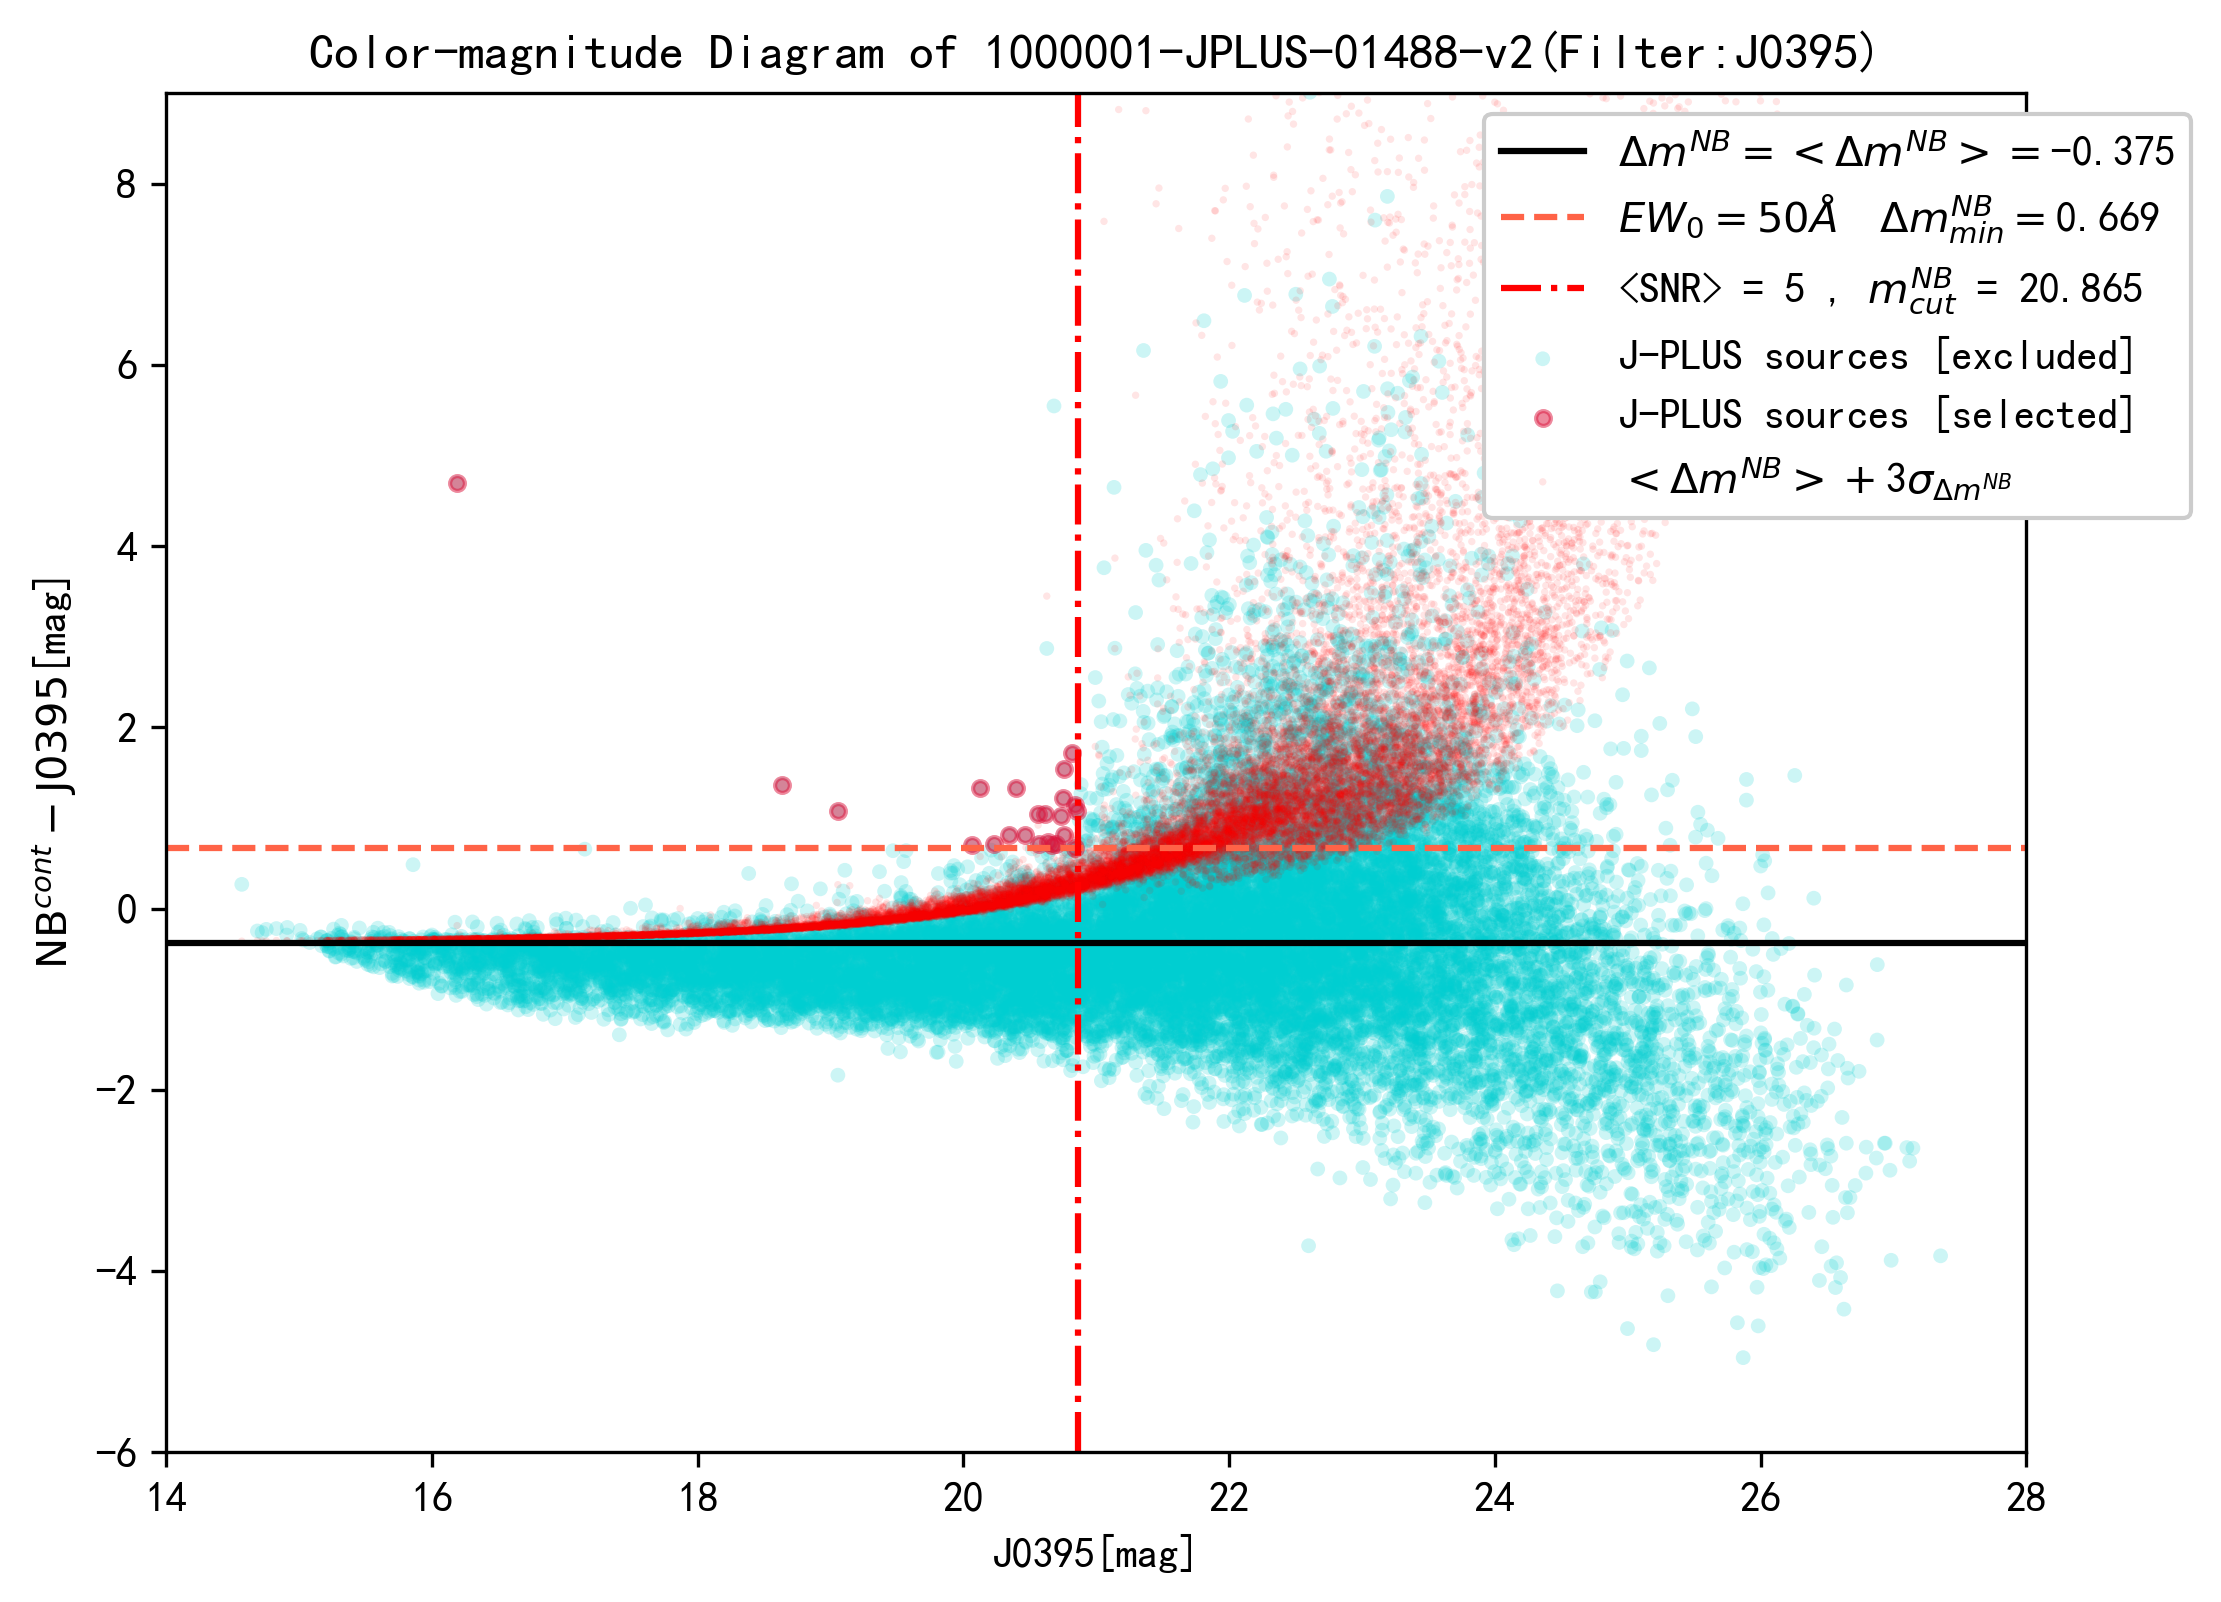

In [23]:
#作图:color-magnitude diagram

plt.figure(figsize=(8,6),dpi=300)           #设置图像大小

plt.scatter(cat_df['mag_iso_gauss_J0395'], cat_df['Delta_ABmag'], s=np.pi*2**2, c='#00CED1', alpha=0.2, label='J-PLUS sources [excluded]', edgecolors='none')
plt.scatter(cat_select_df['mag_iso_gauss_J0395'], cat_select_df['Delta_ABmag'], s=np.pi*2**2, c='#DC143C', alpha=0.5,label='J-PLUS sources [selected]')
plt.scatter(cat_df['mag_iso_gauss_J0395'],Delta_ABmag_mean+SIGMA*Delta_ABmag_err, s=np.pi*1**2, c='r', alpha=0.1, label='$<\Delta m^{NB}> + $'+str(SIGMA)+'$\sigma_{\Delta m^{NB}}$', edgecolors='none')
#plt.scatter(cat_select_df['mag_iso_gauss_J0395'],Delta_ABmag_mean+SIGMA*cat_select_df['Delta_ABmag_err'], s=np.pi*1**2, c='black', alpha=0.8, label='sources', edgecolors='none')
plt.axhline(Delta_ABmag_mean, color='k', linestyle='solid',label='$\Delta m^{NB} = <\Delta m^{NB}>= $'+str('%.3f' %Delta_ABmag_mean))
plt.axhline(Delta_ABmag_min, color='tomato', linestyle='--', linewidth = 1.5,label='$EW_0 = 50 \AA$ '+' $\Delta m^{NB}_{min} = $'+str('%.3f' %Delta_ABmag_min))
plt.axvline(mag_NB_cut, color='r', linestyle='-.', linewidth = 1.5,label='<SNR> = 5 , $m^{NB}_{cut}$ = '+str('%.3f' %mag_NB_cut))
plt.axis([14,28,-6,9])

plt.legend(loc='upper right',numpoints=1,frameon=True,framealpha=1,markerscale=1,bbox_to_anchor=(1.1,1))
plt.title('Color-magnitude Diagram of '+catfile+'(Filter:J0395)')
plt.xlabel('J0395[mag]')
plt.ylabel('$\mathrm{NB}^{cont}-\mathrm{J0395}$[mag]')

#plt.savefig(catfile+'_J0395.png', dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype='letter', format='png',
#        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

plt.show() 

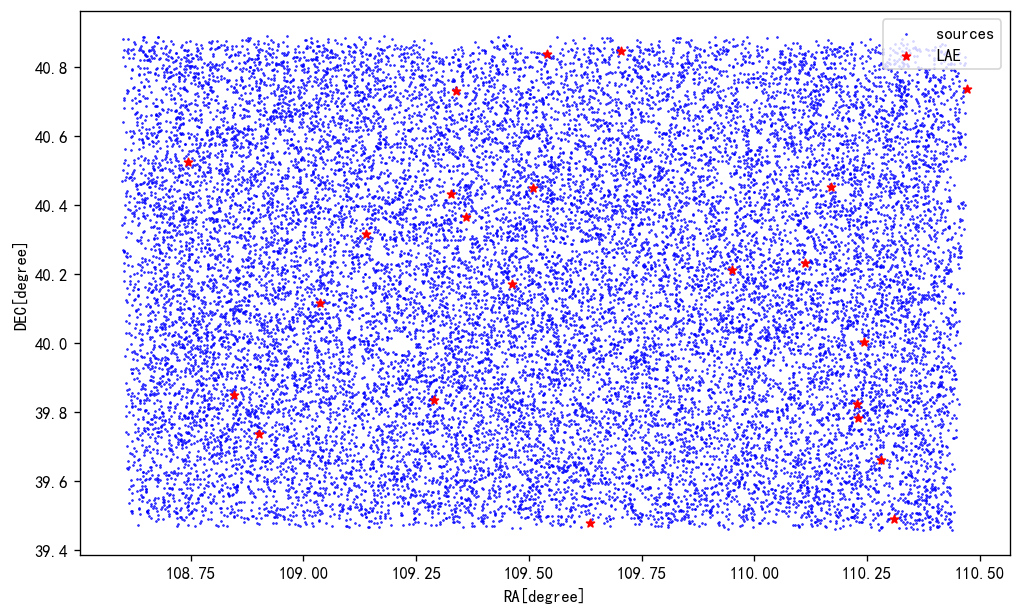

In [25]:
#作图:position
plt.figure(figsize=(10,6),dpi=120)  
#plt.scatter(cat_select_df['x_image'], cat_select_df['y_image'],marker='*', s=1)
plt.scatter(cat_df['alpha_j2000'], cat_df['delta_j2000'],marker='.', color='b', s=1,label='sources')
plt.scatter(cat_select_df['alpha_j2000'], cat_select_df['delta_j2000'],marker='*', color='r', s=25,label='LAE')
plt.xlabel('RA[degree]')
plt.ylabel('DEC[degree]')
plt.legend()
plt.show()